# HMS Capstone - Machine Learning - Linear & Logistic Regression
## By: AJ Goldstein (https://github.com/ajva1996)

### <span style="color:red">Modeling Task: </span>
### Build on Random Forest models by quantifying the relationship between psychological inflexibility (i.e. AAQ) and mental health outcomes (i.e. depression, anxiety, well-being) in US college students

### <span style="color:red">Why Linear & Logistic Regression?</span>
- WHY 1: <b>incredibly high interpretability</b>--> easily understood by non-technical stakeholders
- WHY 2: <b>assumes continous, linear relationship</b>--> observed in the EDA phase
- WHY 3: <b>feature importances were pre-determined</b>--> using results from random forests here

### <span style="color:red">Analysis Steps:</span>
#### 1) Preliminary linear regression fits
    - AAQ, depression, anxiety, wellbeing
#### 2) Simple OLS linear regression
    - X vs. Y for all 3 combinations
#### 3) OLS regression with interaction terms
    - controlling for categorical demographics
#### 4) Logistic Regression for AAQ & Depression
    - visualizing the likelihood for depression across the AAQ spectrum
#### 5) Logistic Regression for AAQ & Anxiety
    - visualizing the likelihood for anxiety across the AAQ spectrum

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("talk")

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/AJGoldstein/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## STEP #0: Carry forward data from previous notebook

In [2]:
# cleaned dataset
%store -r HMS

# separated modules
%store -r HMS_ids
%store -r HMS_demo
%store -r HMS_mhstatus
%store -r HMS_mhhelp
%store -r HMS_aaq

# tidy variable groups
%store -r tidy_race
%store -r tidy_religion
%store -r tidy_degreeType
%store -r tidy_fieldOfStudy
%store -r tidy_activity
%store -r tidy_age
%store -r tidy_gender
%store -r tidy_relig

# classification features matrix and labels
% store -r X
% store -r Y_flourish_cats
% store -r Y_depression_cats
% store -r Y_anxiety_cats

## STEP #1: Preliminary Regression Fits

### 1) psychological inflexibility vs. depression

In [27]:
# create new dataframe with only independent & dependent variables
HMS_vars = pd.concat([HMS_aaq.AAQ_total, HMS.deprawsc, HMS.anx_score, HMS.flourish], axis=1)

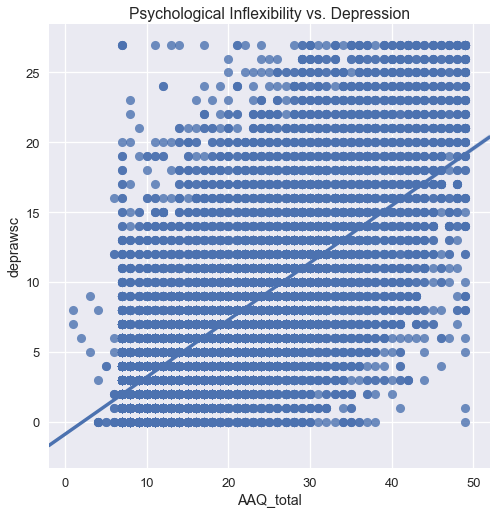

In [67]:
sns.lmplot(x='AAQ_total', y='deprawsc', data=HMS_vars, size=7);
plt.title('Psychological Inflexibility vs. Depression');

### <span style="color:red"> There appears to be a strong, positive linear relationship.</span>
- There are quite a few outliers here, but as a whole, the trend is very strong, which is not surprising
- Intuitively, this could be interpreted as: <span style="color:red">"the more psychologically inflexible a college student is, the worse they will (on average) suffer from depression."</span>

### 2 psychological inflexibility vs. anxiety

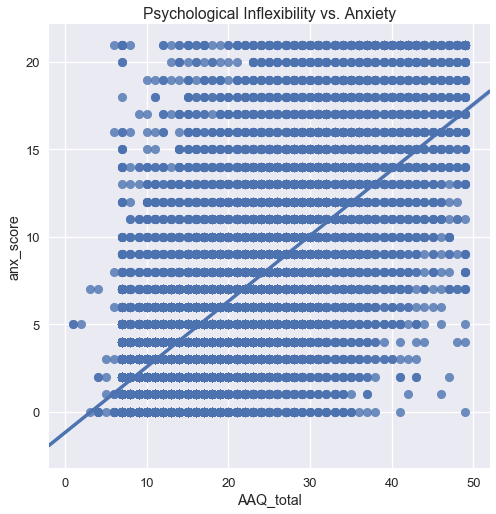

In [29]:
sns.lmplot(x='AAQ_total', y='anx_score', data=HMS_vars, size=7);
plt.title('Psychological Inflexibility vs. Anxiety');

### <span style="color:red"> There appears to be a strong, positive linear relationship.</span>
- There are quite a few outliers here, but as a whole, the trend is very strong, which is not surprising
- Intuitively, this could be interpreted as: <span style="color:red">"the more psychologically inflexible a college student is, the worse they will (on average) suffer from anxiety."</span>

### 3) psychological inflexibility vs. psychological well-being

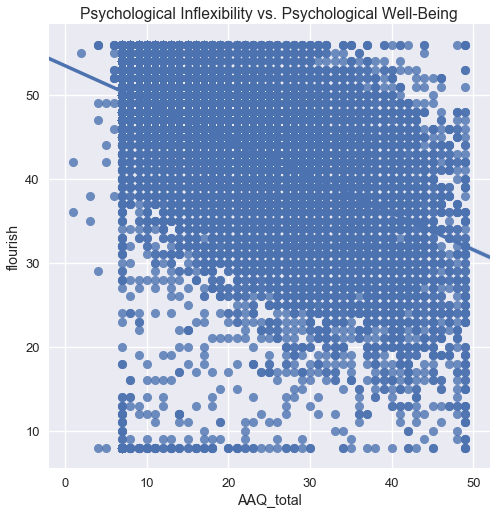

In [30]:
sns.lmplot(x='AAQ_total', y='flourish', data=HMS_vars, size=7);
plt.title('Psychological Inflexibility vs. Psychological Well-Being');

### <span style="color:red"> There appears to be a moderate, negative linear relationship.</span>
- There are many outliers here, but as a whole, the trend is moderate in strength
- Intuitively, this could be interpreted as: <span style="color:red">"the more psychologically inflexible a college student is, the worse their psychological well-being will become."</span>

## STEP #2: Simple OLS Regression

In [31]:
# create RMSE function as absolute measure of fit
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### 1) psychological inflexibility vs. depression

In [32]:
# create training and test set
data = HMS_vars[['deprawsc', 'AAQ_total']].dropna(axis=0, how='any') # only use students with both scores
trainData, testData = train_test_split(data, test_size=0.33)
print('sample size:',len(data))
print('train set:',len(trainData))
print('test:',len(testData))

('sample size:', 23325)
('train set:', 15627)
('test:', 7698)


In [33]:
# perform ordinary least squares (OLS)
model = smf.ols('deprawsc ~ AAQ_total', data=trainData).fit()

# results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               deprawsc   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.291e+04
Date:                Fri, 08 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:39:56   Log-Likelihood:                -45353.
No. Observations:               15627   AIC:                         9.071e+04
Df Residuals:                   15625   BIC:                         9.073e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8581      0.086    -10.013      0.0

In [34]:
# make predictions on test data
predictions = model.predict(testData.AAQ_total)

# calculate root-mean-square-error (RMSE)
print('model RMSE:', rmse(predictions, testData.deprawsc))

('model RMSE:', 4.3691079671921766)


### <span style="color:red">Interpretation:</span>
- <b><span style="color:red">A student's AAQ score is a statistically significant predictor of their depression score (p-value ~= 0) </span></b>
- <b><span style="color:red">For every 1 unit increase in AAQ, we can expect a 0.41 increase in deprawsc.</span></b>

### 2) psychological inflexibility vs. anxiety

In [36]:
# create training and test set
data = HMS_vars[['anx_score', 'AAQ_total']].dropna(axis=0, how='any') # only use students with both scores
trainData, testData = train_test_split(data, test_size=0.33)
print('sample size:',len(data))
print('train set:',len(trainData))
print('test:',len(testData))

('sample size:', 23404)
('train set:', 15680)
('test:', 7724)


In [37]:
# perform ordinary least squares (OLS)
model = smf.ols('anx_score~ AAQ_total', data=trainData).fit()

# results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              anx_score   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.217e+04
Date:                Fri, 08 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:39:56   Log-Likelihood:                -44680.
No. Observations:               15680   AIC:                         8.936e+04
Df Residuals:                   15678   BIC:                         8.938e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1813      0.081    -14.552      0.0

In [38]:
# make predictions on test data
predictions = model.predict(testData.AAQ_total)

# calculate root-mean-square-error (RMSE)
print('model RMSE:', rmse(predictions, testData.anx_score))

('model RMSE:', 4.1110852335182662)


### <span style="color:red">Interpretation:</span>
- <b><span style="color:red">A student's AAQ score is a statistically significant predictor of their anxiety score (p-value ~= 0).</span></b>
- <b><span style="color:red">For every 1 unit increase in AAQ, we can expect a 0.375 increase in anx_score.</span></b>

### 3) psychological inflexibility vs. psychological well-being

In [39]:
# create training and test set
data = HMS_vars[['flourish', 'AAQ_total']].dropna(axis=0, how='any') # only use students with both scores
trainData, testData = train_test_split(data, test_size=0.33)
print('sample size:',len(data))
print('train set:',len(trainData))
print('test:',len(testData))

('sample size:', 24814)
('train set:', 16625)
('test:', 8189)


In [40]:
# perform ordinary least squares (OLS)
model = smf.ols('flourish ~ AAQ_total', data=trainData).fit()

# results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               flourish   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     5575.
Date:                Fri, 08 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:39:56   Log-Likelihood:                -56958.
No. Observations:               16625   AIC:                         1.139e+05
Df Residuals:                   16623   BIC:                         1.139e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.5438      0.140    381.730      0.0

In [41]:
# make predictions on test data
predictions = model.predict(testData.AAQ_total)

# calculate root-mean-square-error (RMSE)
print('model RMSE:', rmse(predictions, testData.flourish))

('model RMSE:', 7.504228470233171)


### <span style="color:red">Interpretation:</span>
- <b><span style="color:red">A student's AAQ score is a statistically significant predictor of their psychological well-being score (p-value ~= 0) </span></b>
- <b><span style="color:red">For every 1 unit increase in AAQ, we can expect a -0.442 decrease in flourish.</span></b>

## STEP #3: OLS Regression with Interaction Terms

### 1) RACE as an interaction

In [42]:
tidy_race.head()

,responseid,flourish,deprawsc,anx_score,AAQ_total,race
16,R_1gvZNcJatOt9lEi,49.0,NaN,NaN,NaN,race_black
34,R_1JOq1q31fzyKpXu,45.0,NaN,NaN,NaN,race_black
40,R_2xwWffFvNbw4BOp,NaN,NaN,NaN,NaN,race_black
49,R_27kz8oG4lLC41TA,43.0,NaN,NaN,NaN,race_black
73,R_1NC8EpaqcDX0CLm,52.0,NaN,NaN,NaN,race_black


In [43]:
# create training and test set
data = tidy_race[['deprawsc', 'AAQ_total', 'race']].dropna(axis=0, how='any') # only use students with both scores
trainData, testData = train_test_split(data, test_size=0.33)
print('sample size:',len(data))
print('train set:',len(trainData))
print('test:',len(testData))

('sample size:', 25814)
('train set:', 17295)
('test:', 8519)


In [44]:
# perform ordinary least squares (OLS)
model = smf.ols('deprawsc ~ AAQ_total + AAQ_total:C(race)', data=trainData).fit()

# results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               deprawsc   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     1844.
Date:                Fri, 08 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:39:57   Log-Likelihood:                -50206.
No. Observations:               17295   AIC:                         1.004e+05
Df Residuals:                   17286   BIC:                         1.005e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

### <span style="color:red">Statistically significant RACES:</span>
### <span style="color:red">ASIAN (p = 0.001) & WHITE (p = 0.004) students have significantly LOWER depression scores</span>

In [45]:
# make predictions on test data
predictions = model.predict(testData[['AAQ_total','race']])

# calculate root-mean-square-error (RMSE)
print('model RMSE:', rmse(predictions, testData.deprawsc))

('model RMSE:', 4.4348979012928611)


## STEP #4: Logistic Regression for Psychological Flexibility & Depression

In [3]:
# split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_flourish_train, y_flourish_test = train_test_split(Y_flourish_cats, test_size=0.3, random_state=0)
y_depression_train, y_depression_test = train_test_split(Y_depression_cats, test_size=0.3, random_state=0)
y_anxiety_train, y_anxiety_test = train_test_split(Y_anxiety_cats, test_size=0.3, random_state=0)

### a) Run statsmodel to generate summary statistics

In [4]:
# run statsmodel to generate logistic regression summary statistics
logit_model = sm.Logit(y_depression_train.reshape(-1,1), sm.add_constant(X_train['AAQ'].reshape(-1,1)))
results = logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.292482
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6280
Model:                          Logit   Df Residuals:                     6278
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Dec 2017   Pseudo R-squ.:                  0.5757
Time:                        19:45:47   Log-Likelihood:                -1836.8
converged:                       True   LL-Null:                       -4328.8
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8628      0.139    -42.050      0.000      -6.136      -5.590
x1             0.2659      0.

In [5]:
print('AAQ Odds Ratio (sklearn):', np.exp(results.params[1]))

('AAQ Odds Ratio (sklearn):', 1.3046626538540764)


### <span style="color:red">Model Interpretation:</span>
#### <span style="color:red">For every 1 unit increase in a student's AAQ score, we expect their odds of being depressed to increase by 30%</span>

### b) Visualize predicted probabilities of depression over AAQ spectrum

In [87]:
# run new Logistic Regression model with sklearn
logreg = LogisticRegression()
logreg.fit(X_train.AAQ.reshape(-1,1), y_depression_train);

In [91]:
# create dataframe of AAQ and predicted probability of depression
df = pd.concat([pd.Series(np.reshape(X_train.AAQ.reshape(-1,1), [6280,])).astype(int),
                pd.Series(logreg.predict_proba(X_train.AAQ.reshape(-1,1))[:, 1])], axis=1)
df.columns = ['AAQ', 'P(depression)']

# add column for probability difference
df2 = pd.DataFrame(df.groupby(['AAQ'])['P(depression)'].mean()).reset_index()
df2['prob diff'] = df2['P(depression)'] - df2['P(depression)'].shift(1)

# display relevant results as proper percentages
#df2['P(depression)'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['P(depression)']], index = df2.index)
#df2['prob diff'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['prob diff']], index = df2.index)
df2.loc[10:26,:]

,AAQ,P(depression),prob diff
10,14,0.109471,0.022987
11,15,0.137647,0.028176
12,16,0.171678,0.034031
13,17,0.212053,0.040375
14,18,0.258955,0.046902
15,19,0.312122,0.053167
16,20,0.370743,0.058621
17,21,0.433437,0.062694
18,22,0.498337,0.064900
19,23,0.563292,0.064956


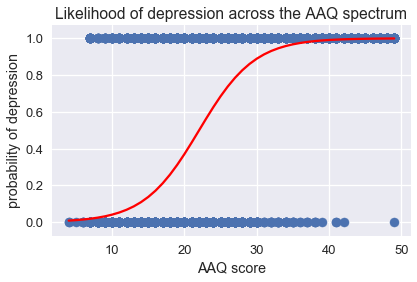

In [92]:
# plot the mean predicted probability of depression across the spectrum of AAQ
plt.scatter(X_train.AAQ.reshape(-1,1), y_depression_train.reshape(-1,1))
plt.plot(df.groupby(['AAQ'])['P(depression)'].mean(), color='red')
plt.xlabel('AAQ score')
plt.ylabel('probability of depression');
plt.title('Likelihood of depression across the AAQ spectrum');
plt.tight_layout(pad=1)
plt.savefig('LogReg_sCurve_dep')

### <span style="color:red"> There is a very strong relationship between a students' AAQ score and their likelihood of being depressed</span>

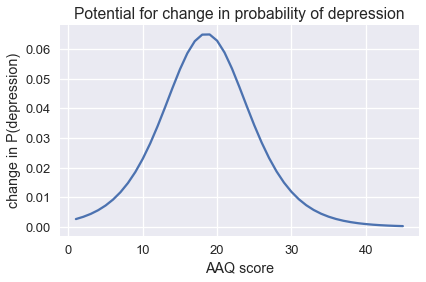

In [93]:
plt.plot(df2['prob diff'])
plt.xlabel('AAQ score')
plt.ylabel('change in P(depression)')
plt.title('Potential for change in probability of depression');
plt.tight_layout(pad=1)
plt.savefig('LogReg_gCurve_dep')

### <span style="color:red"> Students with AAQ scores between 15-30 have the most potential for change in their depression probability </span>

### Test model accuracy

In [76]:
y_dep_preds = logreg.predict(X_test.AAQ.reshape(-1,1))

print('Depression Model Accuracy:', accuracy_score(y_depression_test, y_dep_preds))

('Depression Model Accuracy:', 0.88707280832095092)


### <span style="color:red">With an accuracy of 88.7%, the model is performing incredibly well</span>

### Perform cross validation for check for overfitting

In [77]:
# run cross validation to check for overfitting
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train.AAQ.reshape(-1,1), y_depression_train.reshape(-1,1), cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.884


### <span style="color:red">With an average CV accuracy of 88.4%, the model does not appear to be overfitting to the training data</span>

### Generate confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_depression_test, y_dep_preds)
confusion_df = pd.DataFrame(confusion_matrix, index = ['Actual: Depressed', 'Actual: Not Depressed'], columns = ['Predicted: Depressed', 'Predicted: Not Depressed'])
print(confusion_df)

                       Predicted: Depressed  Predicted: Not Depressed
Actual: Depressed                      1349                       128
Actual: Not Depressed                   176                      1039


### Calculate precision, recall, f1-score, etc.

In [79]:
print(classification_report(y_depression_test, y_dep_preds))

             precision    recall  f1-score   support

          0       0.88      0.91      0.90      1477
          1       0.89      0.86      0.87      1215

avg / total       0.89      0.89      0.89      2692



- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall.
- The support is the number of occurrences of each class in y_test.

###  <span style="color:red">Precision = 89 %  //  Recall = 89%  //  F1-Score = 89%</span>

### Graph ROC Curve

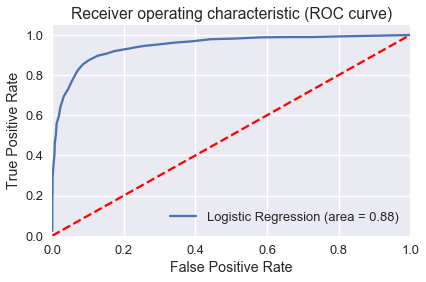

In [80]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_depression_test, logreg.predict(X_test.AAQ.reshape(-1,1)))
fpr, tpr, thresholds = roc_curve(y_depression_test, logreg.predict_proba(X_test.AAQ.reshape(-1,1))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.tight_layout(pad=1)
plt.savefig('LogReg_ROC_dep')
plt.show()

### <span style="color:green">All in all, this logistic regression model appears to conclude that psychological flexibility is a strong, accurate, and positive predictor of depression in American college students. </span>

## STEP #5: Logistic Regression for Psychological Flexibility & Anxiety

### a) Run statsmodel to generate summary statistics

In [81]:
# run statsmodel to generate logistic regression summary statistics
logit_model = sm.Logit(y_anxiety_train.reshape(-1,1), sm.add_constant(X_train['AAQ'].reshape(-1,1)))
results = logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.295717
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6280
Model:                          Logit   Df Residuals:                     6278
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Dec 2017   Pseudo R-squ.:                  0.5666
Time:                        17:43:30   Log-Likelihood:                -1857.1
converged:                       True   LL-Null:                       -4284.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9699      0.141    -42.205      0.000      -6.247      -5.693
x1             0.2554      0.

In [82]:
print('AAQ Odds Ratio (sklearn):', np.exp(results.params[1]))

('AAQ Odds Ratio (sklearn):', 1.2910059309302317)


### <span style="color:red">Model Interpretation:</span>
#### <span style="color:red">For every 1 unit increase in a student's AAQ score, we expect their odds of being clinically anxious to increase by 29%</span>

### b) Visualize predicted probabilities of ANXIETY over AAQ spectrum

In [84]:
# run new Logistic Regression model with sklearn
logreg = LogisticRegression()
logreg.fit(X_train.AAQ.reshape(-1,1), y_anxiety_train);

In [86]:
# create dataframe of AAQ and predicted probability of depression
df = pd.concat([pd.Series(np.reshape(X_train.AAQ.reshape(-1,1), [6280,]).astype(int)),
                pd.Series(logreg.predict_proba(X_train.AAQ.reshape(-1,1))[:, 1])], axis=1)
df.columns = ['AAQ', 'P(anxiety)']

# add column for probability difference
df2 = pd.DataFrame(df.groupby(['AAQ'])['P(anxiety)'].mean()).reset_index()
df2['prob diff'] = df2['P(anxiety)'] - df2['P(anxiety)'].shift(1)

# display relevant results as proper percentages
#df2['P(anxiety)'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['P(anxiety)']], index = df2.index)
#df2['prob diff'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['prob diff']], index = df2.index)
df2.loc[10:26,:]

,AAQ,P(anxiety),prob diff
10,14,0.087600,0.018067
11,15,0.109806,0.022207
12,16,0.136799,0.026992
13,17,0.169165,0.032366
14,18,0.207350,0.038185
15,19,0.251544,0.044195
16,20,0.301575,0.050030
17,21,0.356812,0.055237
18,22,0.416139,0.059326
19,23,0.477998,0.061860


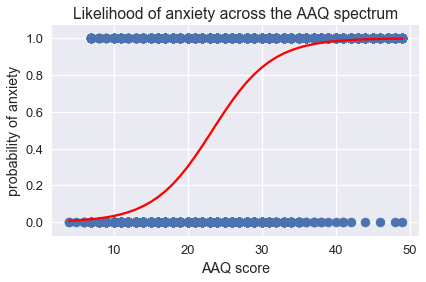

In [56]:
# plot the mean predicted probability of depression across the spectrum of AAQ
plt.scatter(X_train.AAQ.reshape(-1,1), y_anxiety_train.reshape(-1,1))
plt.plot(df.groupby(['AAQ'])['P(anxiety)'].mean(), color='red')
plt.xlabel('AAQ score')
plt.ylabel('probability of anxiety');
plt.title('Likelihood of anxiety across the AAQ spectrum');
plt.tight_layout(pad=1)
plt.savefig('LogReg_sCurve_anx')

### <span style="color:red"> There is a very strong relationship between a students' AAQ score and their likelihood of being anxious</span>

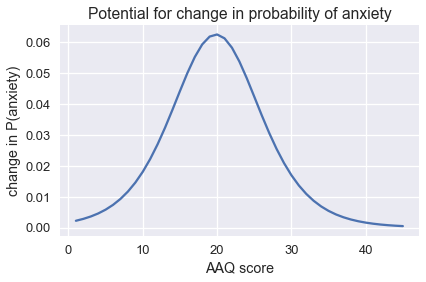

In [63]:
plt.plot(df2['prob diff'])
plt.xlabel('AAQ score')
plt.ylabel('change in P(anxiety)')
plt.title('Potential for change in probability of anxiety');
plt.tight_layout(pad=1)
plt.savefig('LogReg_gCurve_anx')

### <span style="color:red"> Students with AAQ scores between 18-31 have the most potential for change in their anxiety probability </span>

### Test model accuracy

In [58]:
y_anx_preds = logreg.predict(X_test.AAQ.reshape(-1,1))

print('Depression Model Accuracy:', accuracy_score(y_anxiety_test, y_anx_preds))

('Depression Model Accuracy:', 0.88335809806835064)


### <span style="color:red">With an accuracy of 88.3%, the model is performing incredibly well</span>

### Perform cross validation for check for overfitting

In [59]:
# run cross validation to check for overfitting
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train.AAQ.reshape(-1,1), y_anxiety_train.reshape(-1,1), cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.877


### <span style="color:red">With an average CV accuracy of 87.7%, the model does not appear to be overfitting to the training data</span>

### Generate confusion matrix

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_anxiety_test, y_anx_preds)
confusion_df = pd.DataFrame(confusion_matrix, index = ['Actual: Anxious', 'Actual: Not Anxious'], columns = ['Predicted: Anxious', 'Predicted: Not Anxious'])
print(confusion_df)

                     Predicted: Anxious  Predicted: Not Anxious
Actual: Anxious                    1403                     137
Actual: Not Anxious                 177                     975


### Calculate precision, recall, f1-score, etc.

In [61]:
print(classification_report(y_anxiety_test, y_anx_preds))

             precision    recall  f1-score   support

          0       0.89      0.91      0.90      1540
          1       0.88      0.85      0.86      1152

avg / total       0.88      0.88      0.88      2692



- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall.
- The support is the number of occurrences of each class in y_test.

###  <span style="color:red">Precision = 88 %  //  Recall = 88%  //  F1-Score = 88%</span>

### Graph ROC Curve

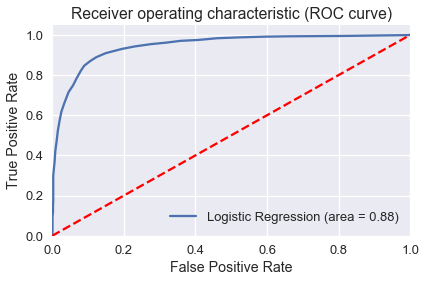

In [62]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_anxiety_test, logreg.predict(X_test.AAQ.reshape(-1,1)))
fpr, tpr, thresholds = roc_curve(y_anxiety_test, logreg.predict_proba(X_test.AAQ.reshape(-1,1))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.tight_layout(pad=1)
plt.savefig('LogReg_ROC_anx')
plt.show()

### <span style="color:green">All in all, this logistic regression model appears to conclude that psychological flexibility is a strong, accurate, and positive predictor of anxiety in American college students. </span>